In [697]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from kneed import KneeLocator

nK = 12                     # initial guess: clusters
RNDN = 42                   # random state

from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.set_option("display.precision",2)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

In [698]:
# read sales data
data = pd.read_csv('set-de-date.csv',sep=';',skiprows=1, usecols=range(22))
#cluster_columns = ['sex', 'varsta','mediu','frecventa_privit_tv','venit_net','cum_consideri_pretul_1','cum_consideri_pretul_2']
#data = data[cluster_columns]

# any missing values?
data.isnull().values.any()


data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   4500 non-null   int64  
 1   sex                                  4436 non-null   object 
 2   varsta                               4436 non-null   float64
 3   mediu                                4409 non-null   object 
 4   judet                                4409 non-null   object 
 5   frecventa_privit_tv                  4361 non-null   object 
 6   ultima_forma_invatamant              4408 non-null   object 
 7   stare_civila                         4408 non-null   object 
 8   cu_copii                             4408 non-null   object 
 9   nr_copii                             3138 non-null   object 
 10  persoane_intretinere                 4499 non-null   float64
 11  ocupatie                      

In [699]:
# elemente unice
print(data.select_dtypes("object").nunique())

# variabile numerice
data.select_dtypes(exclude='object').describe()

sex                              2
mediu                            2
judet                           42
frecventa_privit_tv              9
ultima_forma_invatamant          8
stare_civila                     5
cu_copii                         2
nr_copii                         6
ocupatie                         9
venit_net                       12
atractie_reclama                 5
masura_potrivire_serviciu        5
voi_contracta_serviciile         5
cum_consideri_pretul_1           6
cum_consideri_pretul_2           6
doresti_schimbare_furnizor       5
consideri_servicii_tv_online     5
motiv_nu_te_uiti_la_tv           5
dtype: int64


,ID,varsta,persoane_intretinere,masura_recomandare_serviciu_folosit
count,4500.000,4436.000,4499.000,4314.000
mean,2250.500,497709.753,2.440,8.896
std,1299.182,19135127.759,1.553,1.588
min,1.000,15.000,0.000,0.000
25%,1125.750,33.000,1.000,8.000
50%,2250.500,41.000,2.000,10.000
75%,3375.250,50.000,3.000,10.000
max,4500.000,751498874.000,11.000,10.000


In [700]:
categorical_columns = ['sex','mediu','judet','frecventa_privit_tv','ultima_forma_invatamant','stare_civila',
                       'cu_copii','nr_copii','ocupatie','venit_net','atractie_reclama',
                       'masura_potrivire_serviciu','voi_contracta_serviciile','cum_consideri_pretul_1','cum_consideri_pretul_2',
                      'masura_recomandare_serviciu_folosit','doresti_schimbare_furnizor','consideri_servicii_tv_online',
                       'motiv_nu_te_uiti_la_tv']
def show_column_options(df):
    print('Valori coloane:')
    cols = df.columns
    for col in cols:
        print(col,':',df[col].unique())

show_column_options(data[categorical_columns])

Valori coloane:
sex : ['Barbat' 'Femeie' nan]
mediu : ['Urban' 'Rural' nan]
judet : ['BUCURESTI' 'PRAHOVA' 'ARAD' 'GALATI' 'MURES' 'BOTOSANI' 'COVASNA'
 'CONSTANTA' 'DOLJ' 'OLT' 'IASI' 'BUZAU' 'HUNEDOARA' 'GORJ' 'CLUJ' 'NEAMT'
 'SALAJ' 'BIHOR' 'SUCEAVA' 'HARGHITA' 'IALOMITA' 'TIMIS' 'CARAS-SEVERIN'
 'SATU MARE' 'BRAILA' 'ILFOV' 'MEHEDINTI' 'BACAU' 'ARGES' 'BRASOV' 'SIBIU'
 'BISTRITA-NASAUD' 'CALARASI' 'VALCEA' 'VASLUI' 'TELEORMAN' 'ALBA'
 'DAMBOVITA' 'MARAMURES' 'TULCEA' nan 'VRANCEA' 'GIURGIU']
frecventa_privit_tv : ['Zilnic' 'De 2-3 ori pe saptamana' 'De 4-5 ori pe saptamana'
 'Chiar daca am televizor, nu ma uit niciodata' 'O data pe saptamana' nan
 'O data la cateva luni sau mai rar' 'De 2-3 ori pe luna' 'O data pe luna'
 'Nu am televizor']
ultima_forma_invatamant : [nan 'Studii postuniversitare (master, doctorat)' 'Facultate (3-5 ani)'
 'Gimnaziu (8 clase)' 'Treapta 1 de liceu (10 clase)' 'Liceu (12 clase)'
 'Refuz sa raspund' 'Fara studii' 'scoala primara (4 clase)']
stare_civila 

In [701]:
data["mediu"].value_counts()

Urban    2670
Rural    1739
Name: mediu, dtype: int64

In [702]:
venit_net = {"venit_net":     {"Sub 750 lei": "Sub 1700 lei","751 - 1.000 lei": "Sub 1700 lei",
                               "1.001 - 1.700 lei": "Sub 1700 lei", "1.701 - 2.000 lei": "1.701 - 3.000 lei",
                               "2.001 - 3.000 lei": "1.701 - 3.000 lei","3.001 - 4.000 lei": "3.001 - 5.000 lei",
                               "4.001 - 5.000 lei": "3.001 - 5.000 lei","5.001 - 6.500 lei":"> 5000 lei","> 8000 lei":"> 5000 lei","6.501 - 8.000 lei": "> 5000 lei"}
                }
data = data.replace(venit_net)
data = data[data["venit_net"] != 'Refuz sa raspund']
data["venit_net"].value_counts()

1.701 - 3.000 lei       1458
Sub 1700 lei            1222
Nu realizez venituri     639
3.001 - 5.000 lei        590
> 5000 lei               196
Name: venit_net, dtype: int64

In [703]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append('Altele')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Altele')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

#Call the function with a default threshold of 75%
transformed_column,new_category_list=cumulatively_categorise(data['ultima_forma_invatamant'],0.75,return_categories_list=True)
new_category_list
transformed_column,new_category_list=cumulatively_categorise(data['atractie_reclama'],0.65,return_categories_list=True)
new_category_list

['Asa si-asa', 'imi place mult', 'Altele']

In [704]:
cluster_columns = ['varsta','mediu','atractie_reclama','voi_contracta_serviciile']
data = data[cluster_columns]
data.replace(r'^\s*$', np.nan, regex=True)
data.fillna(data.mode().iloc[0]) ## convert df to a series
data.head()
data.dropna(inplace=True)
#data


In [705]:
data["varsta"].value_counts()

40.000           146
42.000           145
44.000           138
52.000           137
41.000           136
                ... 
81.000             1
723517440.000      1
82.000             1
732638985.000      1
90.000             1
Name: varsta, Length: 73, dtype: int64

In [706]:
import scipy.stats as sp
def remove_outliers(df,columns_to_analyse,threshold = 4):
    z_score = np.abs(sp.zscore(df[columns_to_analyse]))
    df_no_outlier = df.loc[(z_score < threshold).all(axis=1),:].copy()
    print(df_no_outlier.shape)
    return df_no_outlier
numerical_columns=["varsta"]
data = remove_outliers(data,numerical_columns,threshold = 10)

display(data.describe())

(4035, 4)


,varsta
count,4035.000
mean,41.744
std,11.928
min,16.000
25%,33.000
50%,41.000
75%,50.000
max,90.000


In [707]:
data["varsta"].value_counts()

40.000    146
42.000    145
44.000    138
52.000    137
41.000    136
         ... 
82.000      1
90.000      1
81.000      1
77.000      1
83.000      1
Name: varsta, Length: 70, dtype: int64

In [708]:

#dfa1 = data.copy()
dfa1.tail(2)
data.replace(r'^\s*$', np.nan, regex=True)
data.fillna(data.mode().iloc[0]) 
data.head()
data.dropna(inplace=True)
data
#dfa1.isnull().values.any()

#full_data['varsta_bin'] = pd.cut(full_data['varsta'], [0, 20, 30, 45, 60, 100], 
#                              labels=['0-20', '20-30', '30-45', '45-60','60-100'])

,varsta,mediu,atractie_reclama,voi_contracta_serviciile
1,37.000,Urban,Asa si-asa,"Poate da, poate nu"
4,44.000,Urban,Asa si-asa,"Poate da, poate nu"
5,32.000,Urban,Asa si-asa,"Poate da, poate nu"
6,43.000,Urban,Nu-mi place deloc,Probabil da
7,33.000,Urban,Asa si-asa,Cu siguranta nu
...,...,...,...,...
4493,37.000,Urban,Nu prea-mi place,Mai degraba nu
4494,26.000,Rural,Asa si-asa,Probabil da
4496,27.000,Rural,Asa si-asa,"Poate da, poate nu"
4497,33.000,Urban,imi place mult,Cu siguranta da


## A1. Translate Categories to Numerical Variables - kMeans

In [709]:
data_kmeans = data.copy()

In [710]:
# scalarea valorilor numerice
col_num = list(data_kmeans.dtypes[data_kmeans.dtypes == "float64"].index)
if len(col_num) !=0:
    scaler = StandardScaler()
    data_kmeans[col_num] = scaler.fit_transform(data_kmeans[col_num])
    data_kmeans.describe()

In [711]:
# convertirea in coloane numerice
def convert_to_codes(df, col): 
    df[col + "_n"] = df[col].astype("category").cat.codes
    df = df.drop(col, axis=1, inplace=True)
for col in list(data_kmeans.dtypes[data_kmeans.dtypes == np.object].index):
    convert_to_codes(data_kmeans, col)
data_kmeans

,varsta,mediu_n,atractie_reclama_n,voi_contracta_serviciile_n
1,-0.398,1,0,3
4,0.189,1,0,3
5,-0.817,1,0,3
6,0.105,1,2,4
7,-0.733,1,0,1
...,...,...,...,...
4493,-0.398,1,1,2
4494,-1.320,0,0,4
4496,-1.236,0,0,3
4497,-0.733,1,4,0


In [712]:
print(data_kmeans.select_dtypes(exclude="object").nunique())
data_kmeans.describe()

varsta                        70
mediu_n                        2
atractie_reclama_n             5
voi_contracta_serviciile_n     5
dtype: int64


,varsta,mediu_n,atractie_reclama_n,voi_contracta_serviciile_n
count,4035.000,4035.000,4035.000,4035.000
mean,-0.000,0.605,1.527,2.429
std,1.000,0.489,1.647,1.232
min,-2.159,0.000,0.000,0.000
25%,-0.733,0.000,0.000,1.000
50%,-0.062,1.000,1.000,3.000
75%,0.692,1.000,3.000,3.000
max,4.046,1.000,4.000,4.000


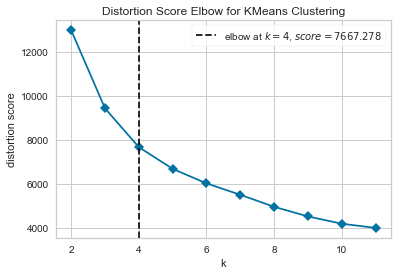

elbow value = optimal k: 4  | elbow score: 7,667.278


In [713]:
# elbow plot using distortion metric

model = KMeans(random_state=RNDN)
visualiser = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric="distortion",
        locate_elbow=True, 
        timings=False)
visualiser.fit(data_kmeans)      
visualiser.show()  
print("elbow value = optimal k:", f'{visualiser.elbow_value_:.0f}', \
            " | elbow score:", f'{visualiser.elbow_score_:,.3f}')
    

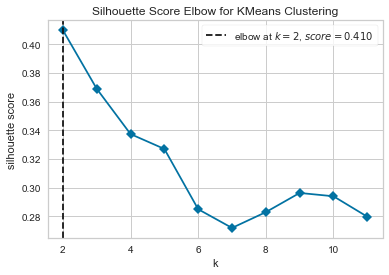

elbow value = optimal k: 2  | elbow score: 0.410


In [714]:
# elbow plot using silhouette metric
visualiser = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric="silhouette",
        locate_elbow=True, 
        timings=False)
visualiser.fit(data_kmeans)      
visualiser.show()  
print("elbow value = optimal k:", f'{visualiser.elbow_value_:.0f}', \
            " | elbow score:", f'{visualiser.elbow_score_:,.3f}')

inertia scores (sum of squared errors) by number of clusters:
2 : 12,987
3 : 9,433
4 : 7,667
5 : 6,679
6 : 6,017
7 : 5,499
8 : 4,952
9 : 4,513
10 : 4,181
11 : 3,989


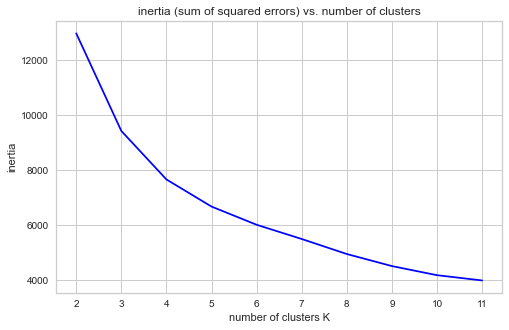

In [715]:
# kmeans: looking for the elbow - compare number of clusters by their inertia scores

# run kMeans for alternative number of clusters k
inertia_scores = [KMeans(
                    n_clusters=k, 
                    init='k-means++', 
                    n_init=10, max_iter=100, random_state=RNDN). \
                    fit(data_kmeans).inertia_ \
                    for k in range(2,nK)]


dict_inertia = dict(zip(range(2,nK), inertia_scores))
print("inertia scores (sum of squared errors) by number of clusters:")
_ = [print(k, ":", f'{v:,.0f}') for k,v in dict_inertia.items()]

# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(range(2,nK), inertia_scores, color="blue")
plt.title("inertia (sum of squared errors) vs. number of clusters")
plt.xticks(np.arange(2,nK,1.0))
plt.xlabel("number of clusters K")
plt.ylabel("inertia");

In [716]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
inertia_knee_a3 = KneeLocator(
        range(2,nK), 
        inertia_scores, 
        S=0.1, curve="convex", direction="decreasing")

K_inertia_a3 = inertia_knee_a3.elbow   
print("elbow at k =", f'{K_inertia_a3:.0f} clusters')

elbow at k = 4 clusters


In [717]:
# kMeans: silhouette score
# initial example: silhouette score for 4 clusters
k = 4
model = KMeans(n_clusters=k, random_state=RNDN, verbose=0)
clusters_assigned = model.fit_predict(data_kmeans)
#K_sil_a3 = silhouette_score(data_kmeans, clusters_assigned)
#print("silhouette score for", k, "clusters: " f'{K_sil_a3:.3f}')

In [718]:
# find maximum silhouette score for up to kN clusters
'''sil_scores = [silhouette_score(
                                data_kmeans, 
                                KMeans(n_clusters=k, random_state=RNDN). \
                                fit_predict(data_kmeans)) \
                                for k in tqdm(range(2,nK))]

dict_sil = dict(zip(range(2,nK), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_a3 = 4 #max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,nK), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,nK,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()'''

'sil_scores = [silhouette_score(\n                                data_kmeans, \n                                KMeans(n_clusters=k, random_state=RNDN).                                 fit_predict(data_kmeans))                                 for k in tqdm(range(2,nK))]\n\ndict_sil = dict(zip(range(2,nK), sil_scores))\nprint("silhouette scores:")\n_ = [print(k, ":", f\'{v:,.3f}\') for k,v in dict_sil.items()]\nK_sil_a3 = 4 #max(dict_sil, key=dict_sil.get)            # optimal clusters\nsil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score\nprint("maximum silhouette score for", f\'{K_sil_a3:.0f} clusters: \', f\'{sil_opt_a3:.3f}\')\n\nplt.figure(figsize=[7,5])\nplt.plot(range(2,nK), sil_scores, color="red")\nplt.title("silhouette scores vs. number of clusters")\nplt.xticks(np.arange(2,nK,1))\nplt.xlabel("number of clusters K")\nplt.ylabel("silhouette score")\nplt.show()'

In [719]:
# %split training vs test dataset
#df_train, df_test = train_test_split(data_kmeans, train_size=0.8, random_state=42)

In [720]:
#rularea modelului pentru obtinerea clusterelor
model = KMeans(n_clusters=k, random_state=42)
clusters = model.fit_predict(data_kmeans)
#inserarea clusterelor ca o coloana
data_kmeans.insert(0, "Cluster", clusters)    
data_kmeans.tail()

,Cluster,varsta,mediu_n,atractie_reclama_n,voi_contracta_serviciile_n
4493,2,-0.398,1,1,2
4494,0,-1.320,0,0,4
4496,0,-1.236,0,0,3
4497,1,-0.733,1,4,0
4498,3,-0.062,1,4,4


In [721]:
# valorile cele mai frecvente
data_kmeans_clusters=data.copy()
data_kmeans_clusters["Cluster"] = data_kmeans["Cluster"]
data_kmeans_clusters.groupby(["Cluster"]).agg(lambda x:x.value_counts().index[0])

,varsta,mediu,atractie_reclama,voi_contracta_serviciile
Cluster,,,,
0,40.000,Urban,Asa si-asa,"Poate da, poate nu"
1,42.000,Urban,Nu-mi place deloc,Cu siguranta nu
2,44.000,Urban,Asa si-asa,Cu siguranta nu
3,43.000,Urban,imi place mult,Probabil da


In [722]:
def cluster_profile(data):
    data_clusters = data.groupby("Cluster").agg({ 
        "varsta": "median",
        "mediu": lambda x: x.value_counts().index[0],
        "voi_contracta_serviciile": lambda x: x.value_counts().index[0],
        "atractie_reclama": lambda x: x.value_counts().index[0],
                                    }).sort_values(by=["varsta"], ascending=False)
    
    # numar de coloane categorice
    col_cat = len(data.select_dtypes("object").nunique())
    
    # numar de clustere
    nr_clustere = data["Cluster"].nunique()

    for k in tqdm(range(nr_clustere)):
        data_cluster_k = data[data["Cluster"]==k]
        varsta = data_cluster_k["varsta"].median()
        nr = data_cluster_k.shape[0]

        fig = plt.figure(figsize=(25, 12))
        fig.suptitle("Cluster " + str(k) + ": " + \
               " nr: | " + f'{nr:,.0f}' + \
                " | varsta medie: " + f'{varsta:.0f}' )
        i=0
        for j in cluster_columns:
            if j!="varsta":
                ax1 = plt.subplot2grid((2,col_cat),(0,i))
                plt.pie(data_cluster_k[j].value_counts(), 
                        labels=data_cluster_k[j].unique())
                plt.title(j)
                i=i+1         
    return data_clusters

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.59it/s]


Cluster,1,0,2,3
varsta,42.000,41.000,41.000,41.000
mediu,Urban,Urban,Urban,Urban
voi_contracta_serviciile,Cu siguranta nu,"Poate da, poate nu",Cu siguranta nu,Probabil da
atractie_reclama,Nu-mi place deloc,Asa si-asa,Asa si-asa,imi place mult


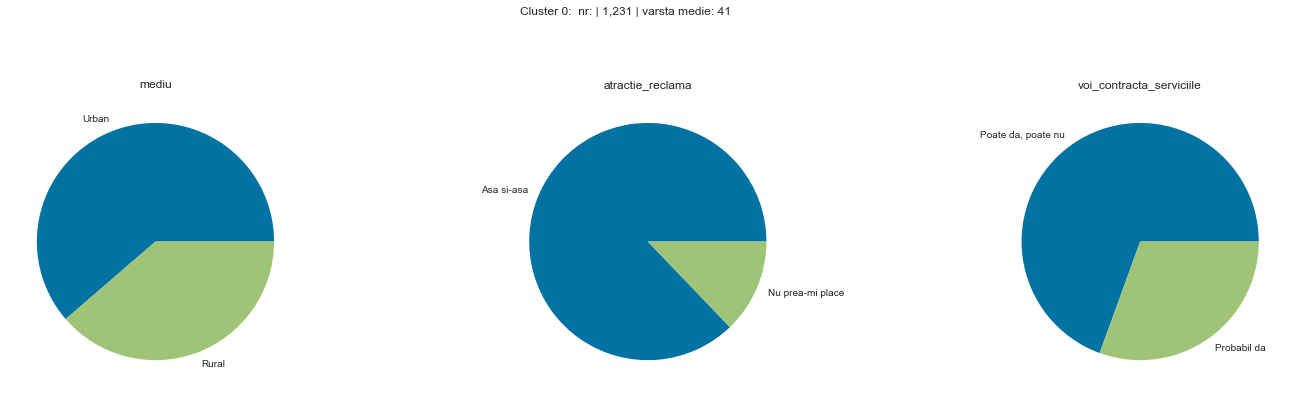

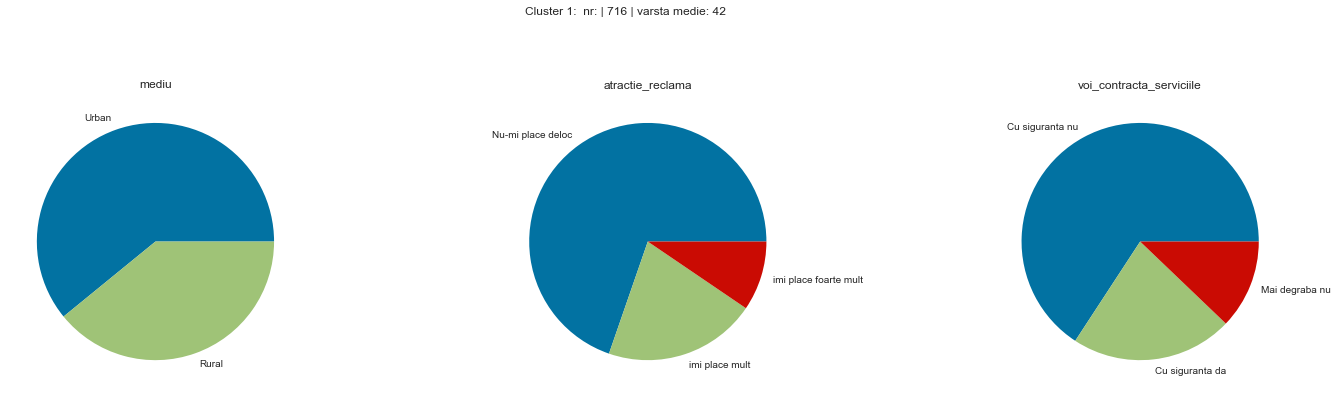

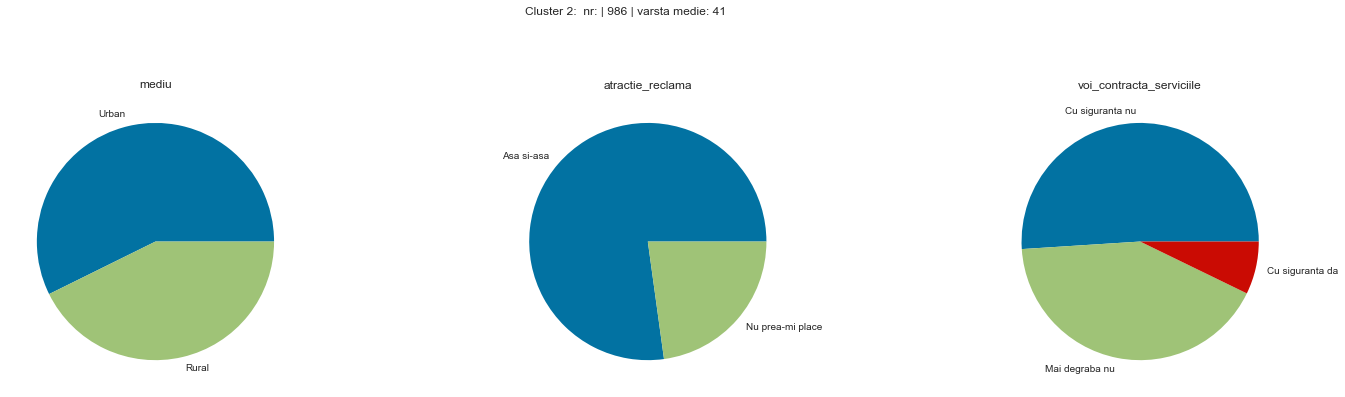

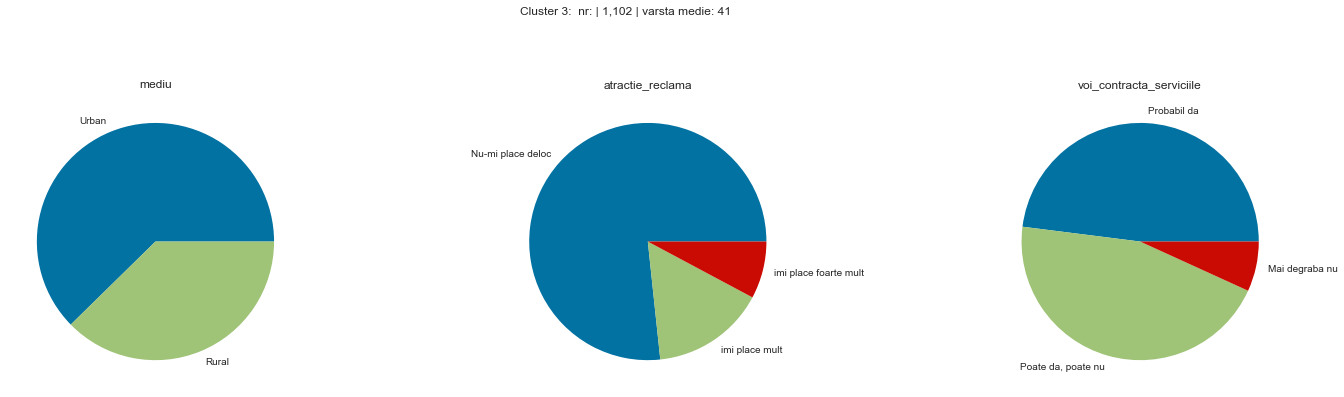

In [723]:
cluster_profile(data_kmeans_clusters).T

# C. k-Prototyping for Mixed Numerical and Categorical Variables

In [724]:
# scalarea valorilor numerice
data_kPrototype = data.copy()
col_num = list(data_kPrototype.dtypes[data_kPrototype.dtypes == "float64"].index)
if len(col_num)!=0:
    scaler = StandardScaler()
    data_kPrototype[col_num] = scaler.fit_transform(data_kPrototype[col_num])
    data_kPrototype.describe()

In [725]:
# get indices of category columns
index_category_columns = [data_kPrototype.columns.get_loc(col) for col in list(data_kPrototype.select_dtypes("object").columns)]
index_category_columns

[1, 2, 3]

In [726]:
# kPrototypes
kProto = KPrototypes(n_clusters = 4, init='Cao', n_jobs = 4)
clusters = kProto.fit_predict(data_kPrototype, categorical=index_category_columns)
kProto.cost_

3553.038423995875

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9


 12%|██████████▌                                                                         | 1/8 [00:08<00:57,  8.25s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 5


 25%|█████████████████████                                                               | 2/8 [00:18<00:57,  9.63s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2


 38%|███████████████████████████████▌                                                    | 3/8 [00:32<00:58, 11.64s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3


 50%|██████████████████████████████████████████                                          | 4/8 [00:46<00:49, 12.29s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 7


 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:00<00:39, 13.12s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:17<00:28, 14.35s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:34<00:15, 15.30s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 5


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:51<00:00, 13.98s/it]

Costurile:
2 : 4674.838
3 : 3992.296
4 : 3562.419
5 : 3260.399
6 : 2983.998
7 : 2846.969
8 : 2615.388
9 : 2543.014


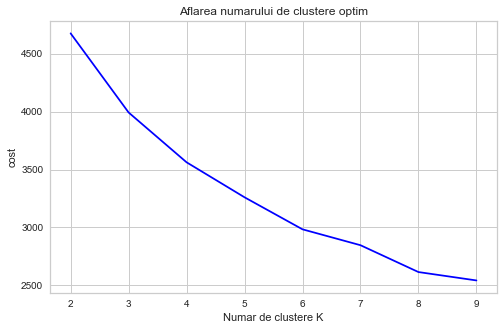

In [727]:
# rularea kPrototypes pentru diferite valori ale lui k pentru aflarea valorii optime
cost_dict = {}
for k in tqdm(range(2,10)):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=4, verbose=2)
    kproto_clusters = kproto.fit_predict(data_kPrototype, categorical=index_category_columns)
    cost_dict[k] = kproto.cost_
#afisarea costurilor pentru diferite valori ale clusterelor
print("Costurile:")
_ = [print(k,":",f'{v:.3f}') for k,v in cost_dict.items()]

#diagrama
plt.figure(figsize=[8,5])
plt.plot(cost_dict.keys(), cost_dict.values(), color="blue")
plt.title("Aflarea numarului de clustere optim")
plt.xticks(np.arange(2,10,1))
plt.xlabel("Numar de clustere K")
plt.ylabel("cost");

In [730]:
# clasa KneeLocator class determina numarul de clustere 
cost = KneeLocator(
        x=list(cost_dict.keys()), 
        y=list(cost_dict.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)
print("elbow la k =", f'{cost.elbow:.0f} clustere')

elbow la k = 4 clustere


In [731]:
data_kPrototype_clusters=data.copy()
data_kPrototype_clusters.insert(0, "Cluster", clusters)  
data_kPrototype_clusters.tail(5)

,Cluster,varsta,mediu,atractie_reclama,voi_contracta_serviciile
4493,2,37.000,Urban,Nu prea-mi place,Mai degraba nu
4494,0,26.000,Rural,Asa si-asa,Probabil da
4496,0,27.000,Rural,Asa si-asa,"Poate da, poate nu"
4497,2,33.000,Urban,imi place mult,Cu siguranta da
4498,2,41.000,Urban,imi place mult,Probabil da


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Cluster,1,3,2,0
varsta,56.000,44.000,41.000,30.000
mediu,Urban,Rural,Urban,Urban
voi_contracta_serviciile,"Poate da, poate nu",Cu siguranta nu,Probabil da,"Poate da, poate nu"
atractie_reclama,Asa si-asa,Asa si-asa,imi place mult,Asa si-asa


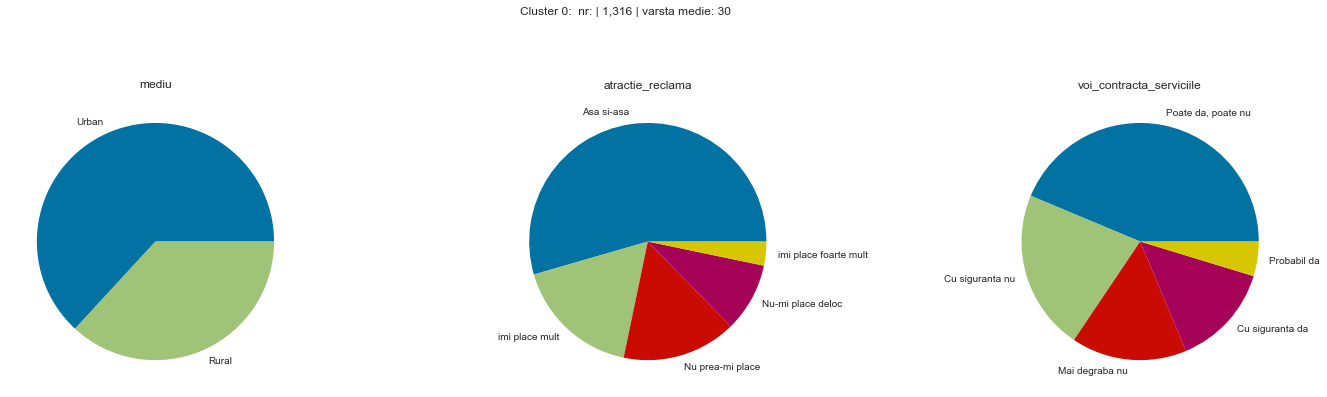

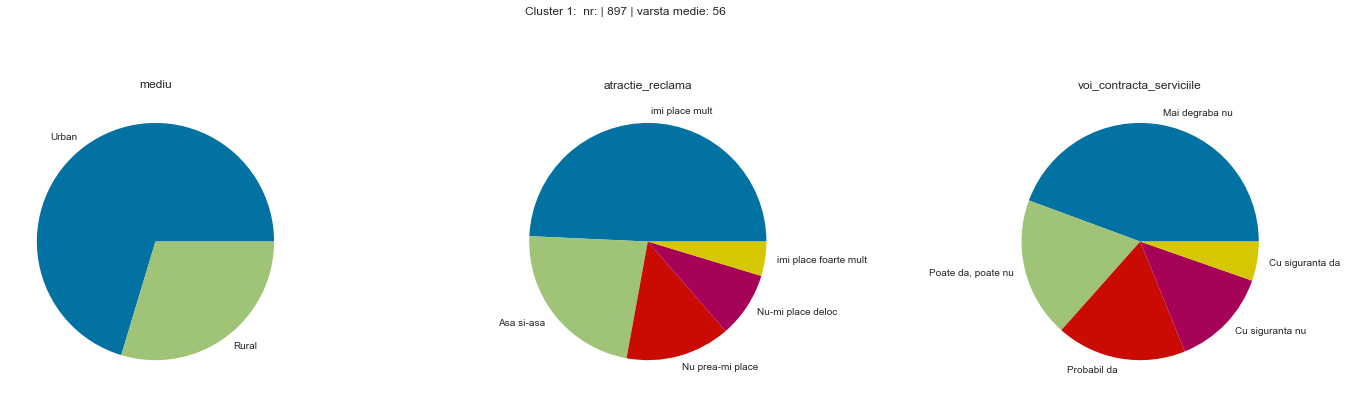

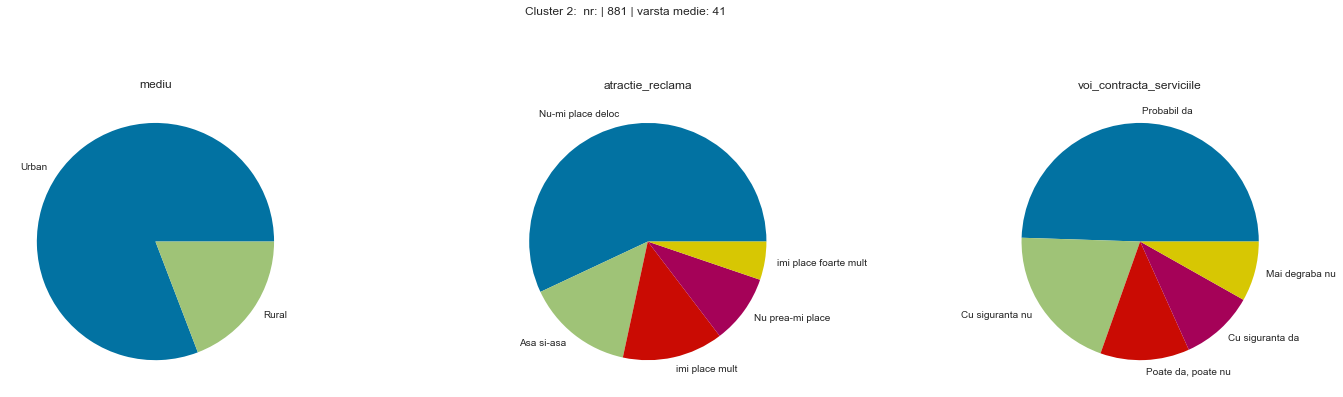

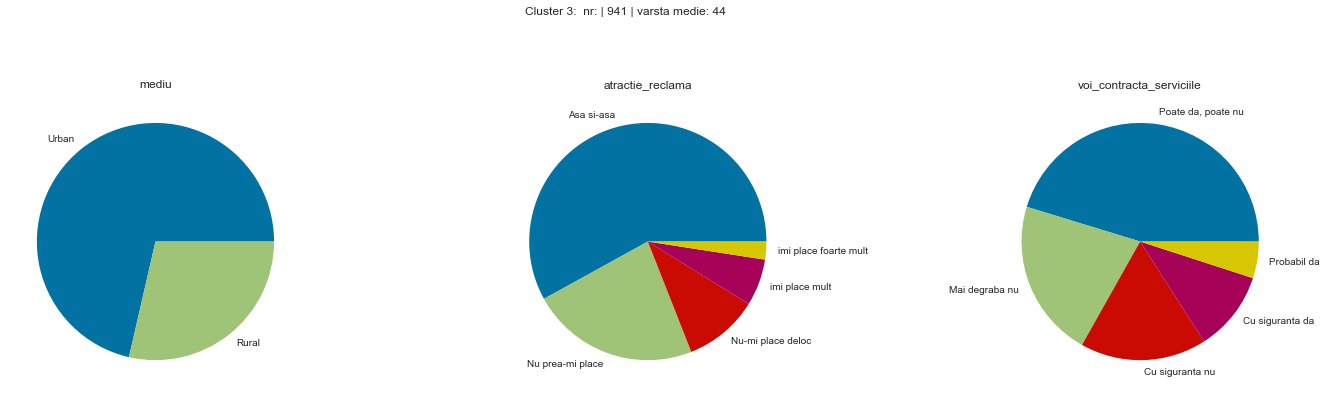

In [732]:
# call cluster profile function
cluster_profile(data_kPrototype_clusters).T